# Work need to be done

1. Plot residual error graph only after each forecast and produce (Durbin Watson Statistic)[https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/]

2. Better visualisation 

# Settings

In [1]:
DATA_CLEANED_PATH = "../data/cleaned_data.csv"

# Time series Analysis Preliminaries

In [2]:
import pandas as pd
data_tourism = pd.read_csv(DATA_CLEANED_PATH)

In [3]:
len(data_tourism)

4466

In [4]:
data_tourism["date"].describe(datetime_is_numeric=False), data_tourism["date"].max()

(count           4466
 unique            58
 top       2019-01-01
 freq              77
 Name: date, dtype: object,
 '2023-10-01')

In [5]:
data_tourism.dtypes

date                   object
province               object
region                 object
ratio_tourist_stay    float64
no_tourist_stay         int64
no_tourist_all          int64
no_tourist_thai         int64
no_tourist_foreign      int64
revenue_all             int64
revenue_thai            int64
revenue_foreign         int64
dtype: object

In [6]:
data_tourism["date"] = pd.to_datetime(data_tourism["date"])

## "revenue_all" analysis

We focus on all nation

In [7]:
# Our problem is about sales, so in this notebook, we focus on revenue_all
data_tourism_revenue_all  = data_tourism[["date", "province", "region", "revenue_all"]]

## divide by 1e6 
import numpy as np
data_tourism_revenue_all["revenue_all"]  = data_tourism_revenue_all["revenue_all"].astype(np.float64) / 1e6

C:\Users\DUC\AppData\Local\Temp\ipykernel_25444\1076620876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tourism_revenue_all["revenue_all"]  = data_tourism_revenue_all["revenue_all"].astype(np.float64) / 1e6


In [8]:
thai_revenue_all = data_tourism_revenue_all.groupby(["date"]).sum("revenue_all").reset_index()
thai_revenue_all.head()

,date,revenue_all
0,2019-01-01,257559.91
1,2019-02-01,231239.97
2,2019-03-01,233165.20
3,2019-04-01,227588.80
4,2019-05-01,206090.92


### Components of Time Series

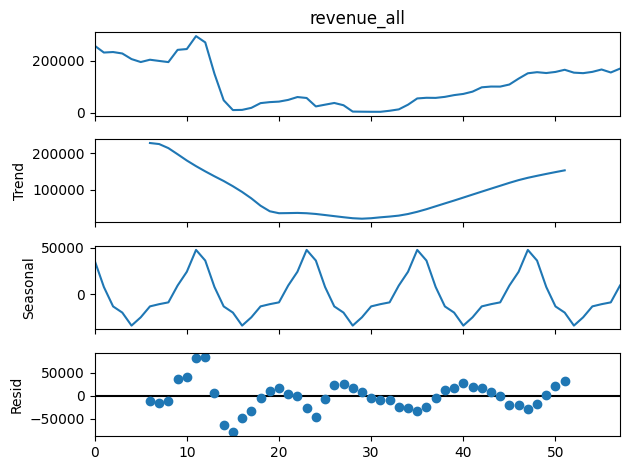

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomp = seasonal_decompose(thai_revenue_all["revenue_all"], model="add", period=12)
decomp.plot()
plt.show()

### Stationarity Testing
Dickey–Fuller test, ACF, PACF

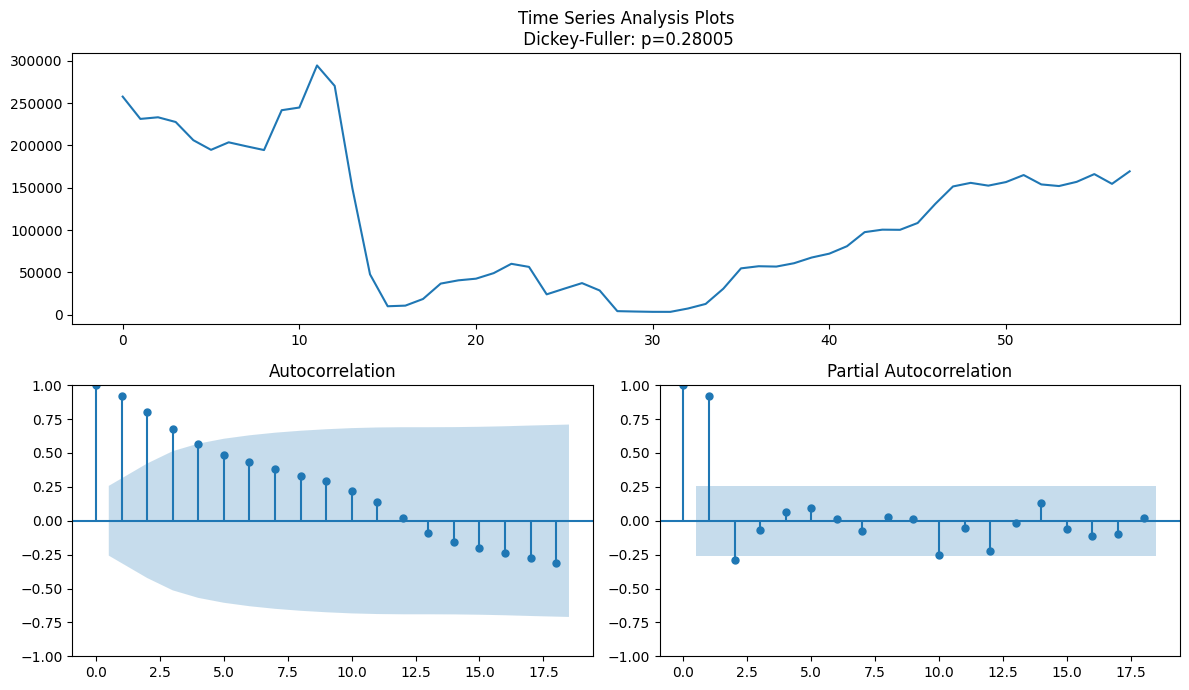

In [10]:
# Check if the revenue is stationary or not ?
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()


tsplot(thai_revenue_all["revenue_all"])

# Modeling

## Forecast Metrics

RMSPE, MAPE 

In [11]:
import numpy as np

def forecast_metric(forecast, actual):
    forecast = np.array(forecast).flatten()
    actual = np.array(actual).flatten()

    mape_result = (np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100).round(2)
    rmspe_result = (
        (np.sqrt(np.mean(np.square((forecast - actual) / actual)))) * 100
    ).round(2)
    return {"RMSPE": rmspe_result, "MAPE": mape_result}

## Split training and test set

Hold out 12 months for evaluation

Forecasting 48 months 

In [12]:
HOLDOUT_MONTH = 12
FORECASTING_MONTH = 48
thai_revenue_all.shape

(58, 2)

In [13]:
thai_revenue_all.tail(5)

,date,revenue_all
53,2023-06-01,151966.899995
54,2023-07-01,156920.359995
55,2023-08-01,166056.739993
56,2023-09-01,154557.719994
57,2023-10-01,169347.069995


In [14]:
train_thai_revenue = thai_revenue_all[:-HOLDOUT_MONTH]
test_thai_revenue = thai_revenue_all[-HOLDOUT_MONTH:] 

## AR 

### Make the data stationary .. 

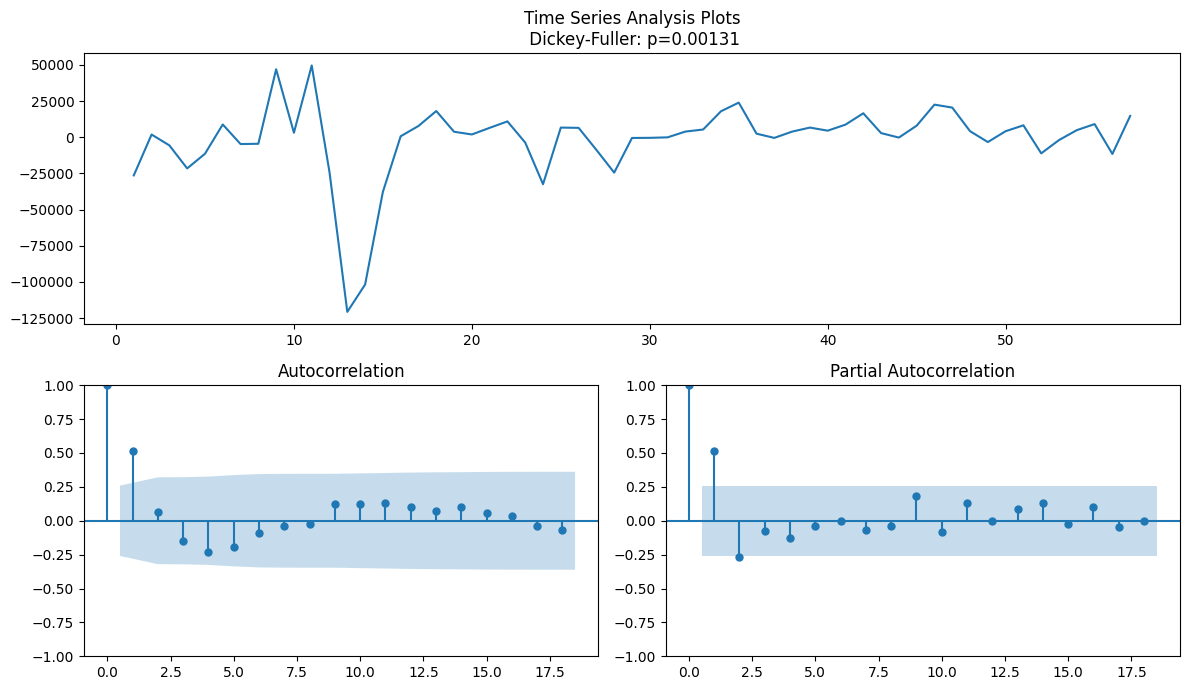

In [15]:
# We check for the difference ...
tsplot(thai_revenue_all["revenue_all"].diff().dropna())

In [16]:
# Set index
train_data = train_thai_revenue.set_index("date")
test_data = test_thai_revenue.set_index("date")

In [17]:
import pmdarima as pm


ARIMAModel = pm.arima.ARIMA((1, 1, 0), suppress_warnings=True)
ARIMAModel.fit(train_data)
ARIMAModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -525.502
Date:                Thu, 21 Dec 2023   AIC                           1057.003
Time:                        21:56:28   BIC                           1062.423
Sample:                    01-01-2019   HQIC                          1059.024
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -929.0588   3176.636     -0.292      0.770   -7155.151    5297.034
ar.L1          0.1233      0.032      3.819      0.000       0.060       0.187
sigma2      5.912e+08      0.161   3.68e+09      0.000    5.91e+08    5.91e+08
===================================================================================
Ljung-Box (L1) (Q):                   8.05   Jarque-Bera (JB):                99.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -2.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.46e+29. Standard errors may be unstable.
"""

In [18]:
forecast, forecast_int = ARIMAModel.predict(n_periods=HOLDOUT_MONTH, 
                                      return_conf_int=True,
                                      alpha=0.05)

In [19]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None, model_name=""):
    metrics = forecast_metric(forecast, series_test)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"{model_name} Prediction with {metrics}", size=16)
    series_train.plot(label="train", color="b", ax=ax)
    series_test.plot(label="test", color="g",ax=ax)
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        ax.fill_between(
            series_test.index,
            forecast_int[:, 0],
            forecast_int[:, 1],
            alpha=0.05,
            color="dimgray",
        )
    ax.legend(prop={"size": 16})
    plt.show()
    return metrics


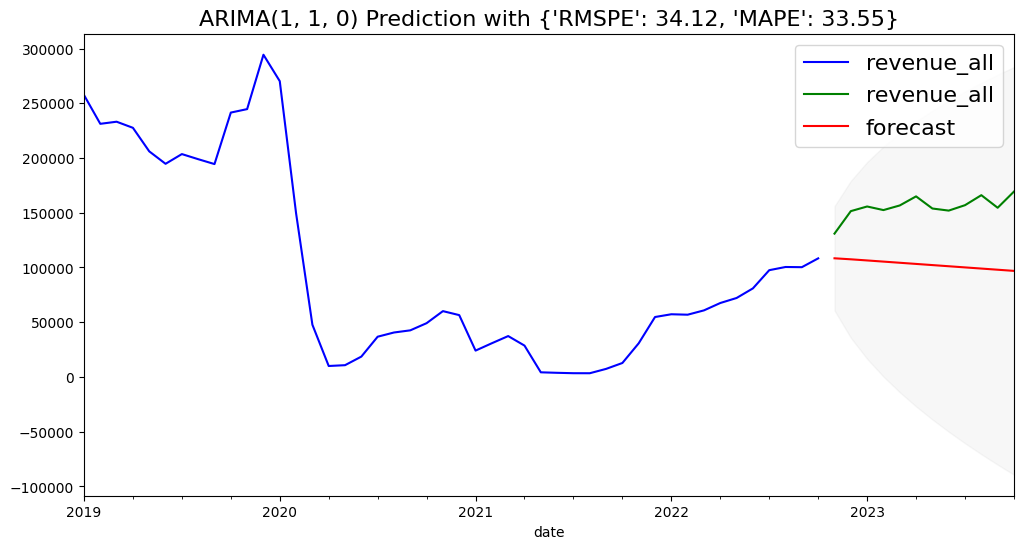

In [20]:
ar_metric = plot_forecast(train_data, 
              test_data,
              forecast,
              forecast_int,
              model_name="ARIMA(1, 1, 0)")
plt.show()

## SARIMA

In [21]:
# Set index
# Set index
train_data = train_thai_revenue.set_index("date")
test_data = test_thai_revenue.set_index("date")

In [22]:
# test_thai_revenue.index[-1]
# Index
# index_months = pd.date_range(test_thai_revenue.index[-1] + pd.DateOffset(months=1), freq="MS", periods=FORECASTING_MONTH)
# index_months

In [23]:
import pmdarima as pm

SARIMAModel = pm.auto_arima(
                        train_data["revenue_all"],
                        start_p=0,
                        start_q=0, 
                        test= "adf",  # use adftest to find optimal 'd'
                        max_p=3,
                        max_q=3,
                        m=12,
                        start_P=0,
                        seasonal=True,
                        D=1,
                        alpha=0.05,
                        trace=False,
                        suppress_warnings=True,
                        stepwise=True)

SARIMAModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   46
Model:             SARIMAX(1, 2, 2)x(0, 1, 2, 12)   Log Likelihood                -375.003
Date:                            Thu, 21 Dec 2023   AIC                            762.006
Time:                                    21:56:41   BIC                            770.800
Sample:                                01-01-2019   HQIC                           764.921
                                     - 10-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4445      0.412      1.078      0.281      -0.364       1.253
ma.L1         -0.9167      0.692     -1.324      0.185      -2.273       0.440
ma.L2         -0.0463      0.369     -0.126      0.900      -0.769       0.676
ma.S.L12      -0.4052      0.607     -0.667      0.505      -1.595       0.785
ma.S.L24      -0.2463      0.131     -1.875      0.061      -0.504       0.011
sigma2      1.195e+09   6.14e-10   1.95e+18      0.000    1.19e+09    1.19e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                37.69
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             1.31
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+34. Standard errors may be unstable.
"""

In [24]:
forecast, forecast_int = SARIMAModel.predict(n_periods=HOLDOUT_MONTH, 
                                      return_conf_int=True,
                                      alpha=0.05)

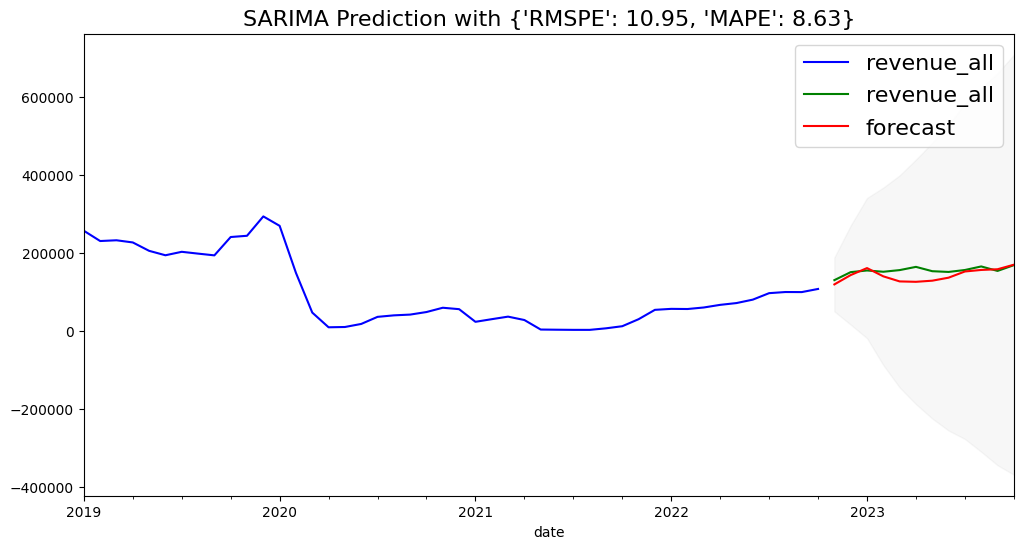

In [25]:
sarima_metric = plot_forecast(train_data, 
              test_data,
              forecast,
              forecast_int,
              model_name="SARIMA")
plt.show()

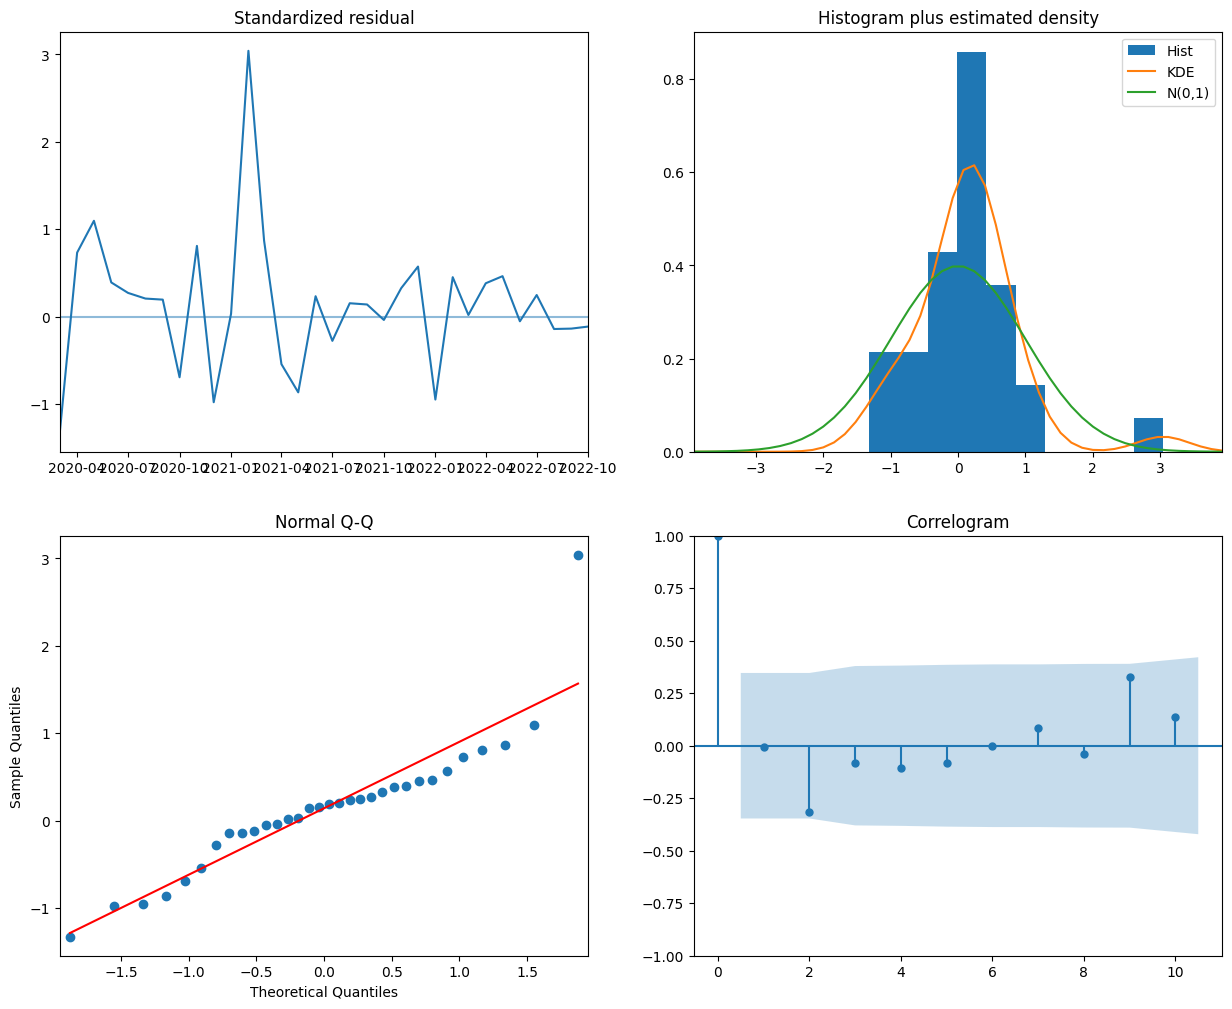

In [26]:
SARIMAModel.plot_diagnostics(figsize=(15,12))
plt.show()

## SARIMAX

with covid cases per month in Thai

In [27]:
import pandas as pd
thai_covid_data  = pd.read_excel("../raw_data/data_thai_covid_case.xlsx")

In [28]:
thai_covid_data = thai_covid_data[["date", "new_cases"]]
thai_covid_data["new_cases"] = thai_covid_data["new_cases"].fillna(0)

In [29]:
thai_covid_data["year"] = thai_covid_data["date"].dt.year
thai_covid_data["month"] = thai_covid_data["date"].dt.month


In [30]:
thai_covid_data_groupby = thai_covid_data.groupby(["year", "month"]).sum("new_cases").reset_index()
thai_covid_data_groupby

,year,month,new_cases
0,2020,1,32.0
1,2020,2,41.0
2,2020,3,1613.0
3,2020,4,1303.0
4,2020,5,127.0
5,2020,6,90.0
6,2020,7,139.0
7,2020,8,102.0
8,2020,9,152.0
9,2020,10,216.0


In [31]:
thai_covid_data_groupby["date"] = pd.to_datetime(dict(year=thai_covid_data_groupby.year, month=thai_covid_data_groupby.month, day=1))

In [32]:
thai_covid_data_groupby = thai_covid_data_groupby[["date", "new_cases"]]

In [33]:
new_date_data = list(pd.date_range(start=train_thai_revenue["date"].min(), freq="MS", end=thai_covid_data_groupby["date"].min()))

In [34]:
list_added_data = []
for sample_data in new_date_data:
    list_added_data.append({"date": sample_data, "new_cases": 0})

In [35]:
thai_covid_data_groupby = thai_covid_data_groupby.append(list_added_data)
thai_covid_data_groupby.sort_values(by = "date", inplace=True)

C:\Users\DUC\AppData\Local\Temp\ipykernel_25444\2663409483.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  thai_covid_data_groupby = thai_covid_data_groupby.append(list_added_data)


In [36]:
thai_covid_data_groupby

,date,new_cases
0,2019-01-01,0.0
1,2019-02-01,0.0
2,2019-03-01,0.0
3,2019-04-01,0.0
4,2019-05-01,0.0
...,...,...
43,2023-08-01,1231.0
44,2023-09-01,1067.0
45,2023-10-01,652.0
46,2023-11-01,1461.0


In [37]:
train_data = train_thai_revenue.set_index("date")
test_data = test_thai_revenue.set_index("date")
covid_data = thai_covid_data_groupby.set_index("date")

In [38]:
train_covid_data = covid_data[:len(train_thai_revenue)].values
test_covid_data = np.ones((HOLDOUT_MONTH, 1 )) * covid_data["new_cases"][-1]

In [39]:
import pmdarima as pm

SARIMAModel = pm.auto_arima(
                        y=train_data["revenue_all"],
                        X=train_covid_data,
                        start_p=1,
                        start_q=1, 
                        test= "adf",  # use adftest to find optimal 'd'
                        max_p=3,
                        max_q=3,
                        m=12,
                        start_P=0,
                        seasonal=True,
                        D=1,
                        alpha=0.05,
                        suppress_warnings=True,
                        stepwise=True)

SARIMAModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   46
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 12)   Log Likelihood                -383.482
Date:                              Thu, 21 Dec 2023   AIC                            780.963
Time:                                      21:56:49   BIC                            791.439
Sample:                                  01-01-2019   HQIC                           784.488
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0017      0.154      0.011      0.991      -0.299       0.303
ar.L1          0.4406      0.230      1.914      0.056      -0.011       0.892
ar.L2          0.0121      0.129      0.094      0.925      -0.241       0.265
ar.S.L12       0.2518      0.360      0.700      0.484      -0.453       0.957
ar.S.L24      -0.1770      0.138     -1.285      0.199      -0.447       0.093
ma.S.L12      -0.6942      0.504     -1.378      0.168      -1.682       0.293
sigma2      8.626e+08   1.18e-09   7.34e+17      0.000    8.63e+08    8.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                21.79
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.92
Prob(H) (two-sided):                  0.40   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+33. Standard errors may be unstable.
"""

In [40]:
forecast, forecast_int = SARIMAModel.predict(n_periods=HOLDOUT_MONTH,
                                             X=test_covid_data,
                                           return_conf_int=True,
                                          alpha=0.05)

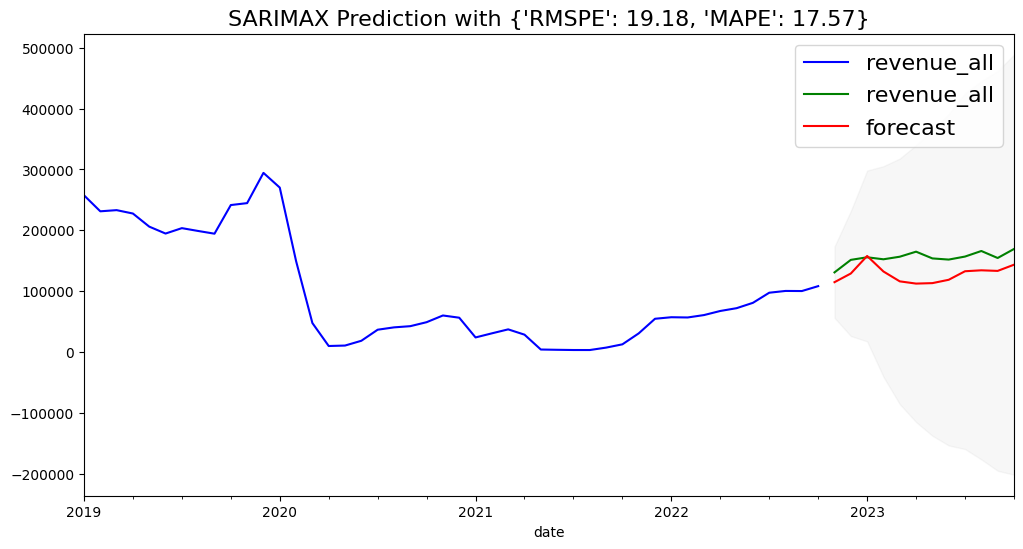

In [41]:
sarima_metric = plot_forecast(train_data, 
              test_data,
              forecast,
              forecast_int,
              model_name="SARIMAX")
plt.show()

## Prophet

In [42]:
train_data = train_thai_revenue.rename(columns={"date": "ds", "revenue_all": "y"})
test_data = test_thai_revenue.rename(columns={"date": "ds", "revenue_all": "y"})

### Normal Settings

In [43]:
from prophet import Prophet
prophet_model = Prophet()

Importing plotly failed. Interactive plots will not work.


In [44]:
prophet_model.fit(train_data)

21:56:49 - cmdstanpy - INFO - Chain [1] start processing


21:56:50 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
future = prophet_model.make_future_dataframe(periods=HOLDOUT_MONTH,freq='MS')
test_prediced_result = prophet_model.predict(future)

In [46]:
prophet_pred = pd.DataFrame({"Date" : test_prediced_result[-HOLDOUT_MONTH:]['ds'], "Pred" : test_prediced_result[-HOLDOUT_MONTH:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Date,
2022-11-01,3206.740854
2022-12-01,39753.490276
2023-01-01,32189.223510
2023-02-01,-26126.669393
2023-03-01,-39618.303050
2023-04-01,-29275.155211
2023-05-01,-46310.873984
2023-06-01,-54879.116514
2023-07-01,-47473.778095


In [47]:
forecast_metric(prophet_pred["Pred"], test_data["y"])

{'RMSPE': 117.05, 'MAPE': 115.28}

### Handling Shocks

In [48]:
# Python
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-01', 'lower_window': 0, 'ds_upper': '2020-06-01'},
    {'holiday': 'lockdown_2', 'ds': '2021-05-01', 'lower_window': 0, 'ds_upper': '2021-09-01'},
])

for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns


,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-01,0,2020-06-01,92
1,lockdown_2,2021-05-01,0,2021-09-01,123


In [49]:
from prophet import Prophet
prophet_model = Prophet(holidays=lockdowns)

In [50]:
prophet_model.fit(train_data)

21:56:50 - cmdstanpy - INFO - Chain [1] start processing


21:56:53 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
future = prophet_model.make_future_dataframe(periods=HOLDOUT_MONTH,freq='MS')
test_prediced_result = prophet_model.predict(future)

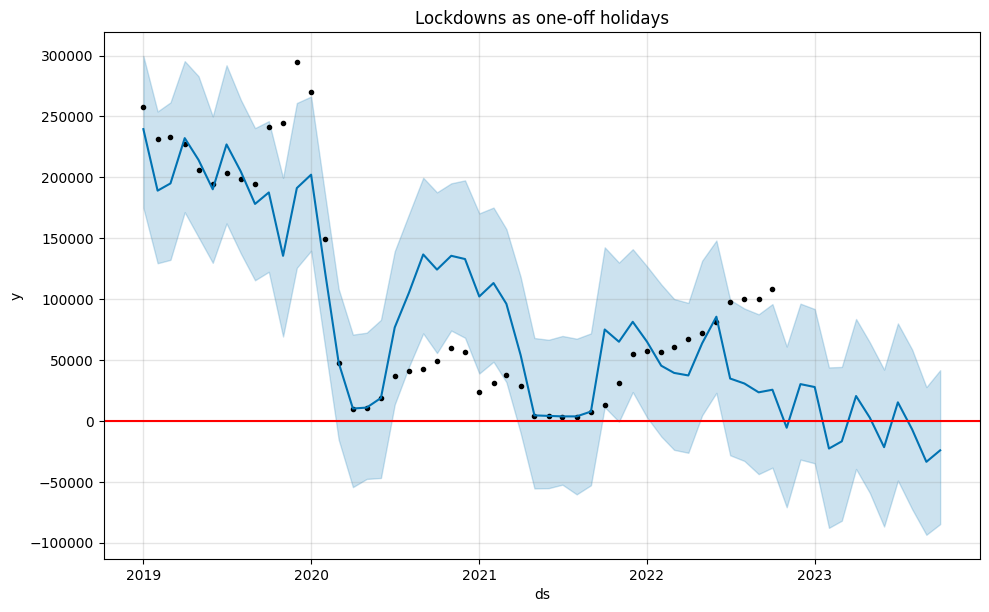

In [52]:
prophet_model.plot(test_prediced_result)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');

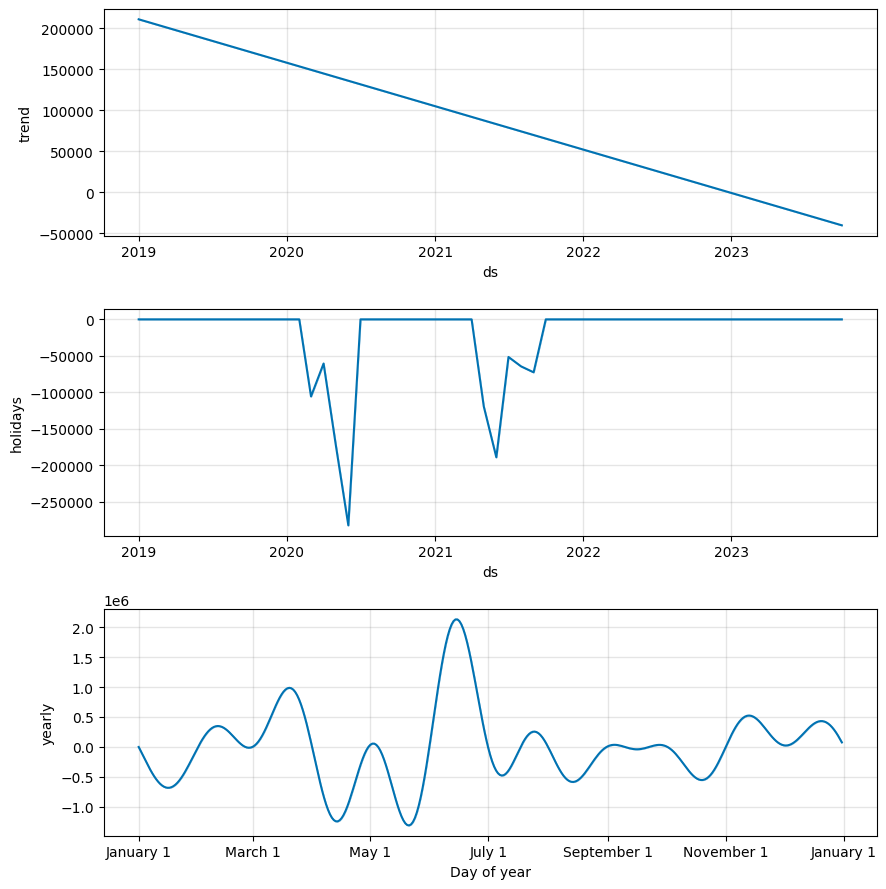

In [53]:
prophet_model.plot_components(test_prediced_result);


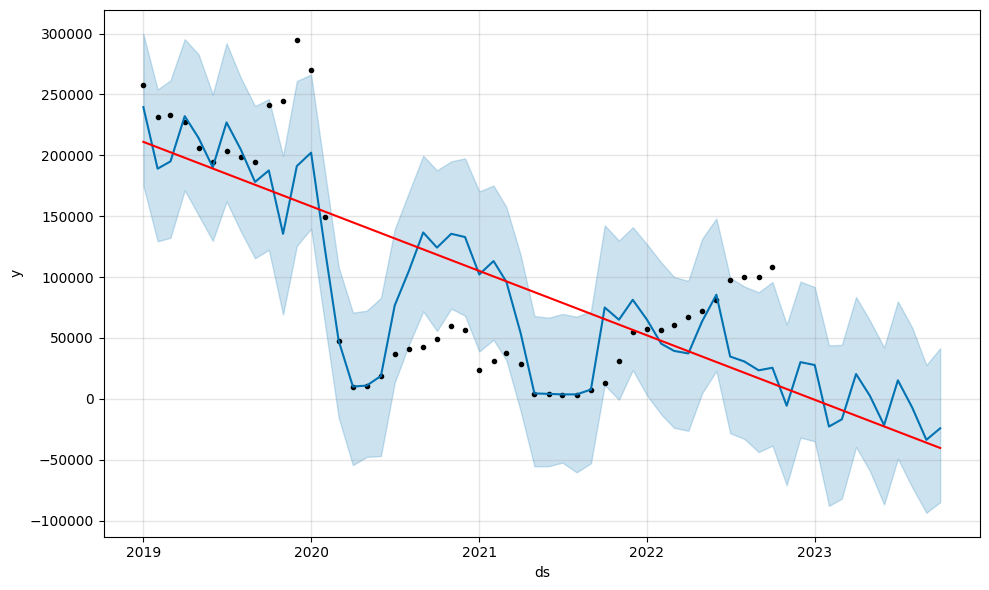

In [54]:
from prophet.plot import add_changepoints_to_plot
fig = prophet_model.plot(test_prediced_result)
a = add_changepoints_to_plot(fig.gca(), prophet_model, test_prediced_result)


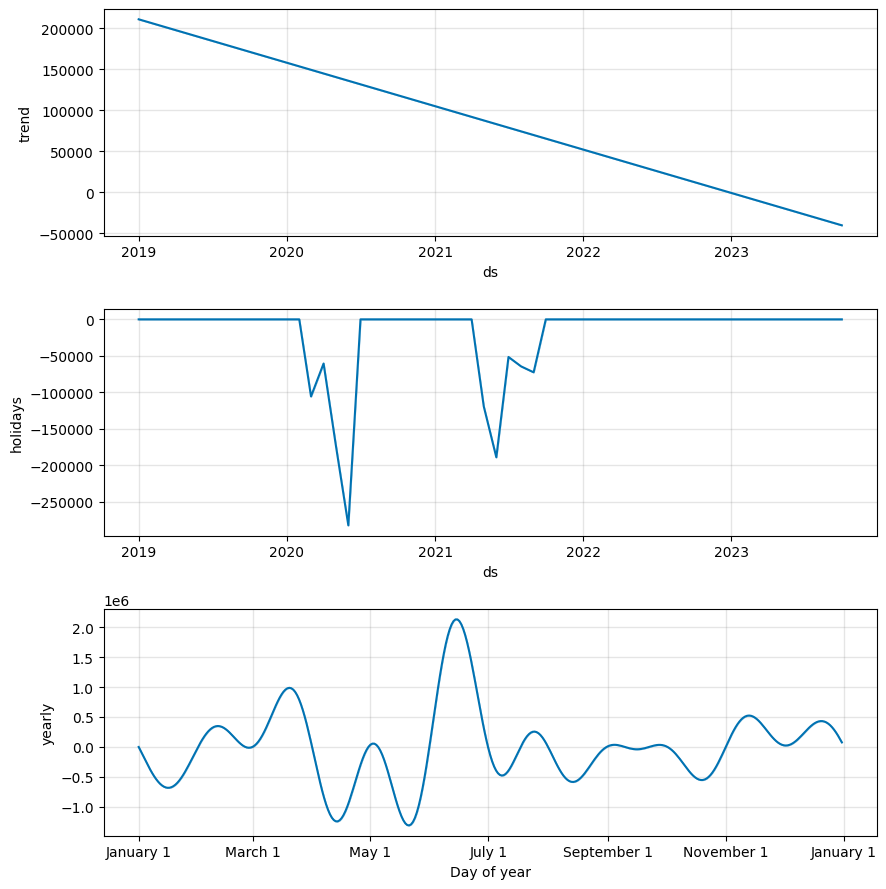

In [55]:
prophet_model.plot_components(test_prediced_result);


In [56]:
# Python
import datetime
changepoints = (
    # 5 potential changepoints this time
    pd.date_range('2020-07-01', '2021-04-01', periods=5).date.tolist() + 
    [datetime.date(2021, 9, 1)]
    # 1 potential changepoints in 1 year 2 months
)


In [57]:
from prophet import Prophet
prophet_model = Prophet(holidays=lockdowns, changepoints=changepoints, changepoint_prior_scale=0.15)
prophet_model.fit(train_data)

21:56:55 - cmdstanpy - INFO - Chain [1] start processing
21:56:57 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
future = prophet_model.make_future_dataframe(periods=HOLDOUT_MONTH,freq='MS')
test_prediced_result = prophet_model.predict(future)

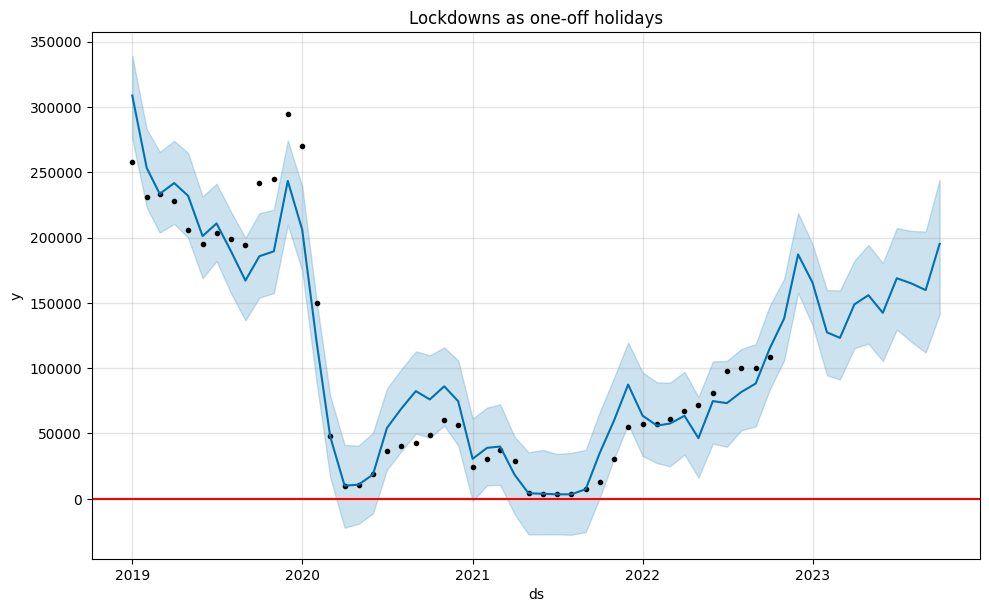

In [59]:
prophet_model.plot(test_prediced_result)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');


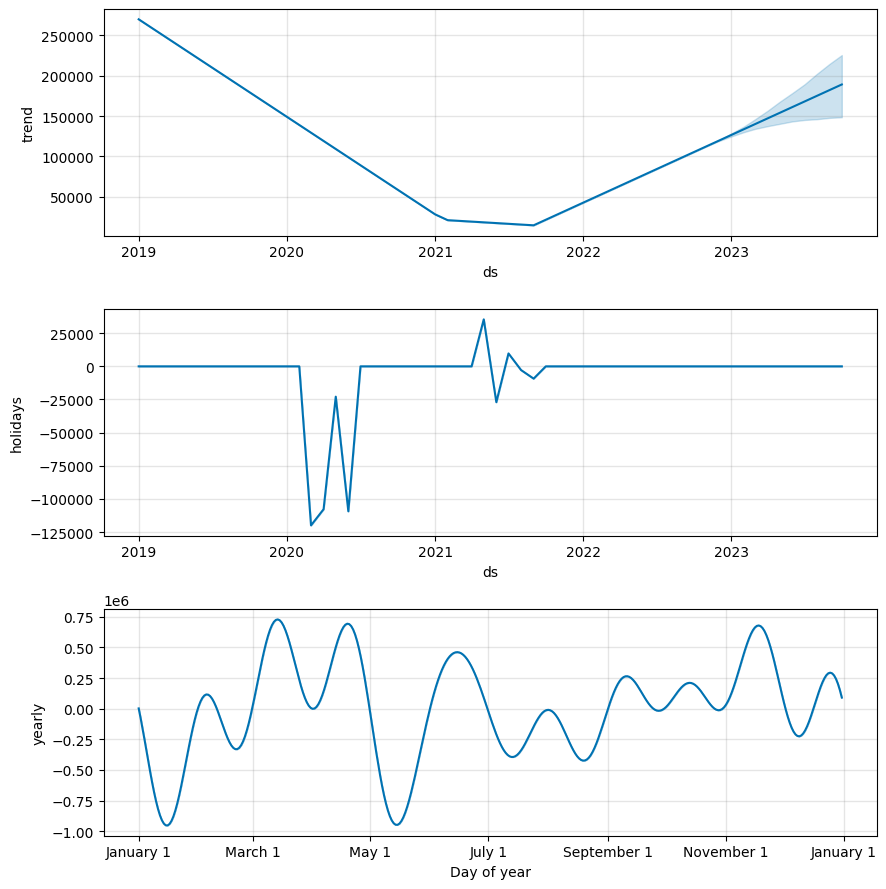

In [60]:
prophet_model.plot_components(test_prediced_result);


In [61]:
prophet_pred = pd.DataFrame({"Date" : test_prediced_result[-HOLDOUT_MONTH:]['ds'], "Pred" : test_prediced_result[-HOLDOUT_MONTH:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

forecast_metric(prophet_pred["Pred"], test_data["y"])

{'RMSPE': 12.19, 'MAPE': 9.76}

In [62]:
df_covid = train_data.copy()
df_covid['pre_covid'] = pd.to_datetime(df_covid['ds']) < pd.to_datetime('2020-03-21')
df_covid['post_covid'] = ~df_covid['pre_covid']

In [63]:
prophet_model = Prophet(holidays=lockdowns, 
                        yearly_seasonality=False, 
                        changepoints=changepoints, 
                        changepoint_prior_scale=0.15)

# Python
prophet_model.add_seasonality(
    name='yearly_pre_covid',
    period=365,
    fourier_order=10,
    condition_name='pre_covid',
    prior_scale=30
)

prophet_model.add_seasonality(
    name='yearly_post_covid',
    period=365,
    fourier_order=10,
    condition_name='post_covid',
    prior_scale=80
);

prophet_model.fit(df_covid)

21:56:58 - cmdstanpy - INFO - Chain [1] start processing


21:57:01 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
future = prophet_model.make_future_dataframe(periods=HOLDOUT_MONTH,freq='MS')
future['pre_covid'] = pd.to_datetime(future['ds']) < pd.to_datetime('2020-03-21')
future['post_covid'] = ~future['pre_covid']

test_prediced_result = prophet_model.predict(future)


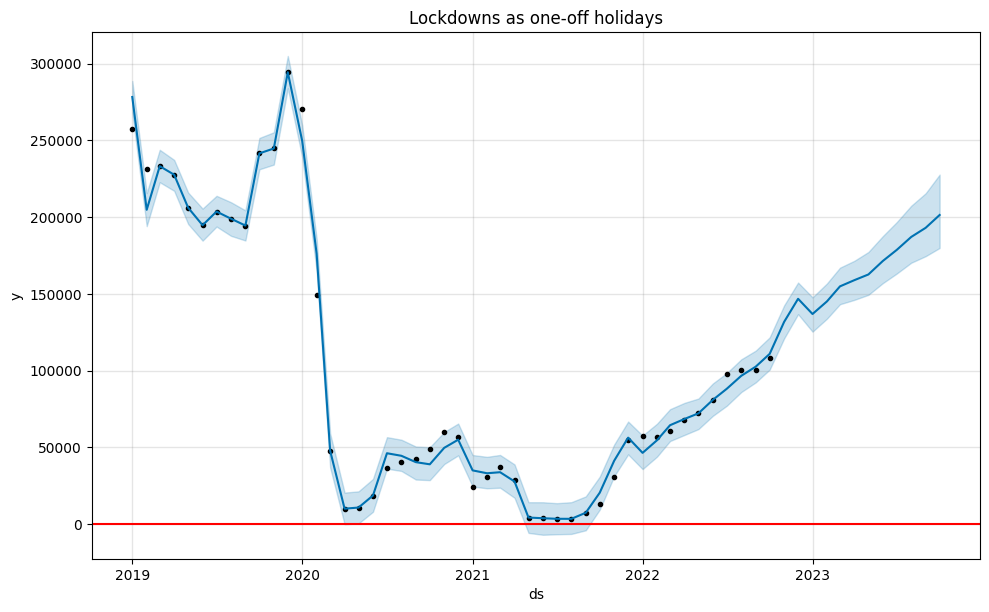

In [65]:
prophet_model.plot(test_prediced_result)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');


In [66]:
prophet_pred = pd.DataFrame({"Date" : test_prediced_result[-HOLDOUT_MONTH:]['ds'], "Pred" : test_prediced_result[-HOLDOUT_MONTH:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

forecast_metric(prophet_pred["Pred"], test_data["y"])

{'RMSPE': 11.96, 'MAPE': 9.52}

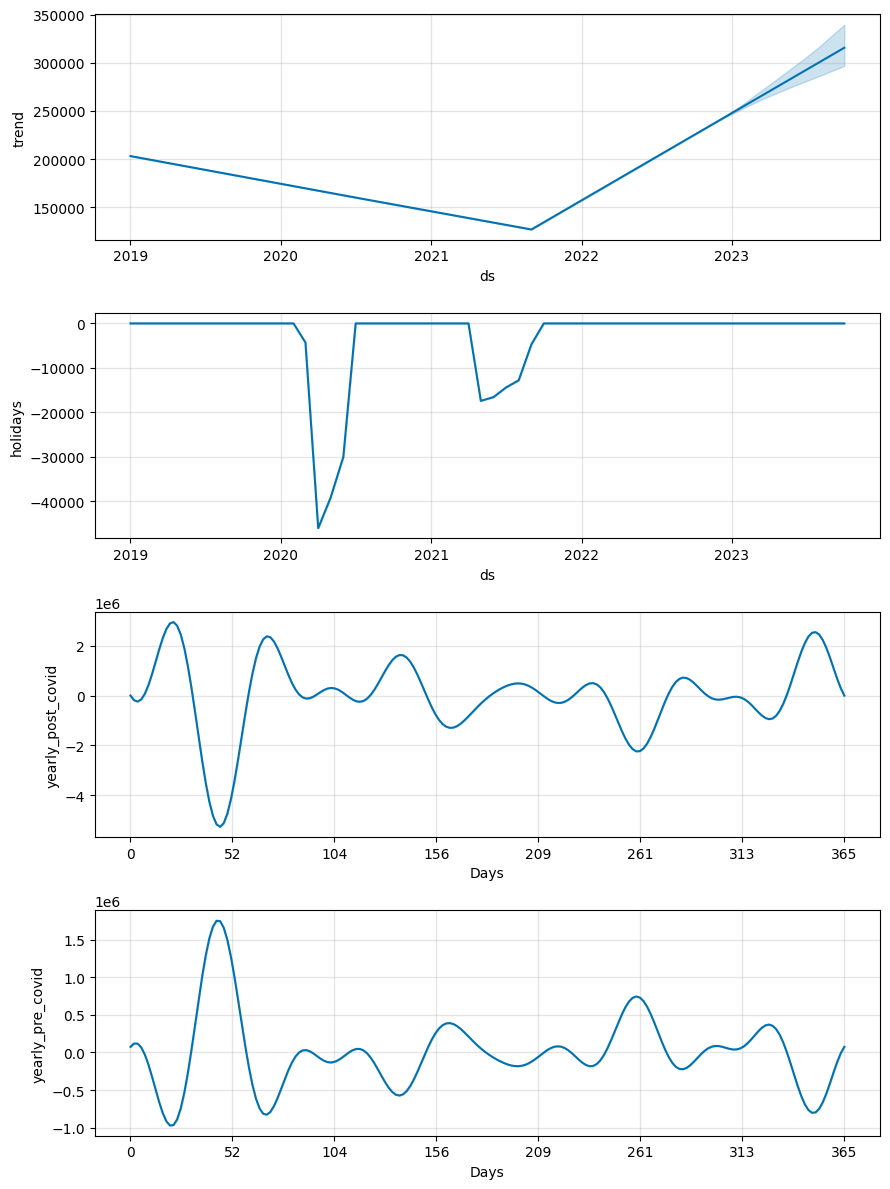

In [67]:
prophet_model.plot_components(test_prediced_result);


In [68]:
train_covid_data = covid_data.reset_index().rename(columns={"date": "ds", "new_cases": "covid_case"}).merge(train_data, on="ds")

In [69]:
df_covid = train_covid_data.copy()
df_covid['pre_covid'] = pd.to_datetime(df_covid['ds']) < pd.to_datetime('2020-03-21')
df_covid['post_covid'] = ~df_covid['pre_covid']

In [70]:
prophet_model = Prophet(holidays=lockdowns, 
                        yearly_seasonality=False, 
                        changepoints=changepoints, 
                        changepoint_prior_scale=0.1)

# Python
prophet_model.add_seasonality(
    name='yearly_pre_covid',
    period=365,
    fourier_order=10,
    condition_name='pre_covid',
    prior_scale=30
)

prophet_model.add_seasonality(
    name='yearly_post_covid',
    period=365,
    fourier_order=10,
    condition_name='post_covid',
    prior_scale=80
)

prophet_model.add_regressor("covid_case")

prophet_model.fit(df_covid)

21:57:02 - cmdstanpy - INFO - Chain [1] start processing


21:57:04 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
future = prophet_model.make_future_dataframe(periods=HOLDOUT_MONTH,freq='MS')
future['pre_covid'] = pd.to_datetime(future['ds']) < pd.to_datetime('2020-03-21')
future['post_covid'] = ~future['pre_covid']
future['covid_case'] = 1400

test_prediced_result = prophet_model.predict(future)


In [72]:
prophet_pred = pd.DataFrame({"Date" : test_prediced_result[-HOLDOUT_MONTH:]['ds'], "Pred" : test_prediced_result[-HOLDOUT_MONTH:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

forecast_metric(prophet_pred["Pred"], test_data["y"])

{'RMSPE': 10.19, 'MAPE': 8.75}

## VAR

### All variables analysis

We focus on all nation, we also focus or everything from "revenue_all"

In [73]:
data_tourism_processed = data_tourism.copy()
data_tourism_processed = data_tourism_processed.drop(columns=["no_tourist_all", "revenue_all"])
data_tourism_processed

,date,province,region,ratio_tourist_stay,no_tourist_stay,no_tourist_thai,no_tourist_foreign,revenue_thai,revenue_foreign
0,2019-01-01,Bangkok,central,0.9337,3334971,3534061,2425014,29742580000,52183910000
1,2019-01-01,Lopburi,central,0.6132,51858,266301,2363,451830000,5410000
2,2019-01-01,Phra Nakhon Si Ayutthaya,central,0.7337,117052,561553,168776,1054250000,384480000
3,2019-01-01,Saraburi,central,0.6733,89850,201400,5836,336190000,11600000
4,2019-01-01,Chainat,central,0.7931,27141,78514,559,100900000,890000
...,...,...,...,...,...,...,...,...,...
4461,2023-10-01,Roi Et,east_northeast,0.4092,25466,61530,924,79870000,2410000
4462,2023-10-01,Sisaket,south,0.4684,26470,83471,344,102190000,860000
4463,2023-10-01,Surin,east_northeast,0.5071,65693,91175,2246,160140000,4440000
4464,2023-10-01,Amnat Charoen,east_northeast,0.3414,5832,19610,423,22260000,740000


In [74]:
# Our problem is about sales, so in this notebook, we focus on revenue, we know that no_tourist_all  =  no_tourist_thai + no_tourist_foreign, revenue_all = revenue_thai + revenue_foreign

## divide by 1e6 
import numpy as np

normalized_factor = 1e6
normalized_columns = ["no_tourist_stay", "no_tourist_thai", 
                      "no_tourist_foreign", "revenue_thai", "revenue_foreign"]


for column in normalized_columns:
    data_tourism_processed[column]  = data_tourism_processed[column].astype(np.float64) / normalized_factor


In [75]:
data_tourism_processed.head()

,date,province,region,ratio_tourist_stay,no_tourist_stay,no_tourist_thai,no_tourist_foreign,revenue_thai,revenue_foreign
0,2019-01-01,Bangkok,central,0.9337,3.334971,3.534061,2.425014,29742.58,52183.91
1,2019-01-01,Lopburi,central,0.6132,0.051858,0.266301,0.002363,451.83,5.41
2,2019-01-01,Phra Nakhon Si Ayutthaya,central,0.7337,0.117052,0.561553,0.168776,1054.25,384.48
3,2019-01-01,Saraburi,central,0.6733,0.089850,0.201400,0.005836,336.19,11.60
4,2019-01-01,Chainat,central,0.7931,0.027141,0.078514,0.000559,100.90,0.89


In [76]:
thai_all = data_tourism_processed.groupby(["date"]).sum().reset_index()
thai_all.head()

C:\Users\DUC\AppData\Local\Temp\ipykernel_25444\3153573436.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  thai_all = data_tourism_processed.groupby(["date"]).sum().reset_index()


,date,ratio_tourist_stay,no_tourist_stay,no_tourist_thai,no_tourist_foreign,revenue_thai,revenue_foreign
0,2019-01-01,54.3414,16.395855,20.702028,7.907122,94564.42,162995.49
1,2019-02-01,52.4556,14.854979,18.469033,7.189186,87387.18,143852.79
2,2019-03-01,49.9166,14.792744,18.752954,7.139471,87090.57,146074.63
3,2019-04-01,48.6096,14.829087,19.269246,6.947580,90057.22,137531.58
4,2019-05-01,45.4773,13.668195,18.493578,6.078770,85480.62,120610.30


In [77]:
thai_all.loc[:, "ratio_tourist_stay"] = data_tourism_processed[["date", "ratio_tourist_stay"]].groupby(["date"]).mean("ratio_tourist_stay").reset_index()["ratio_tourist_stay"].to_list()

In [78]:
thai_all.tail(5)

,date,ratio_tourist_stay,no_tourist_stay,no_tourist_thai,no_tourist_foreign,revenue_thai,revenue_foreign
53,2023-06-01,0.532097,11.535673,19.182171,5.395166,59547.89,92419.009999
54,2023-07-01,0.543436,11.984948,19.788551,5.461253,62280.45,94639.909999
55,2023-08-01,0.550694,12.202802,20.142251,5.622441,64439.24,101617.499998
56,2023-09-01,0.535696,11.495368,19.509529,4.958906,62495.64,92062.080000
57,2023-10-01,0.563575,12.122858,20.751539,5.193241,68775.47,100571.600000


In [79]:
thai_all["date"]  = pd.to_datetime(thai_all["date"])
thai_all = thai_all.set_index("date")

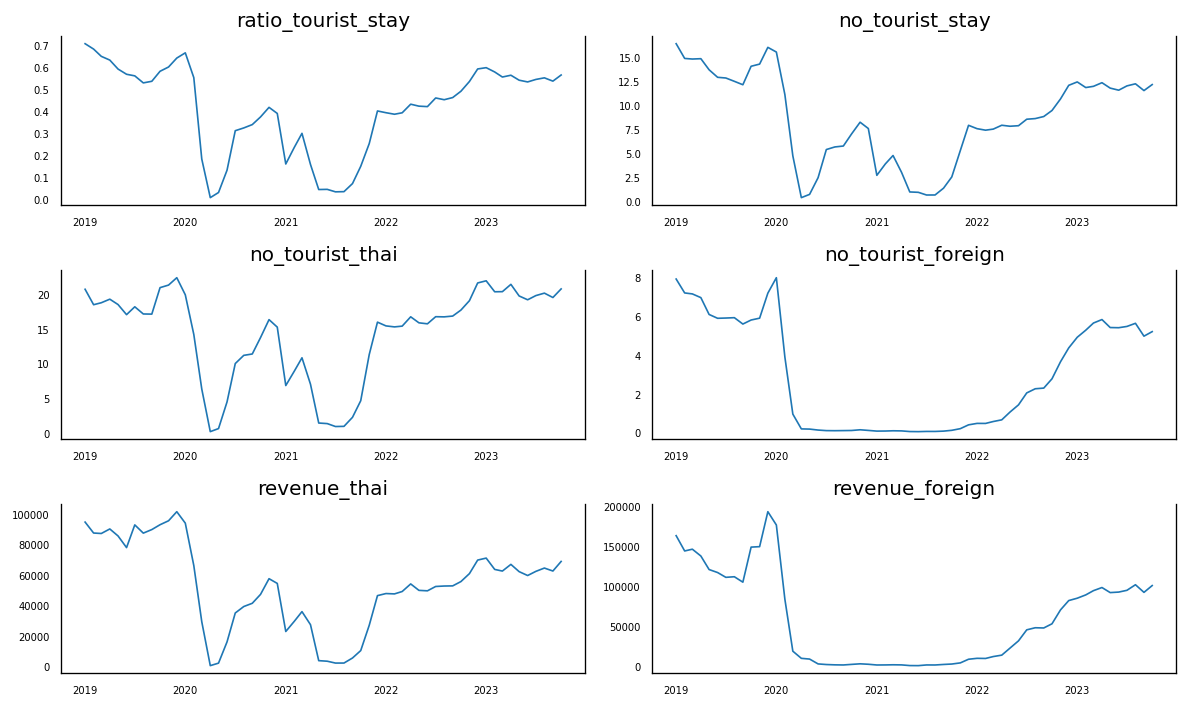

In [80]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = thai_all[thai_all.columns[i]]
    ax.plot(data, linewidth=1)
    # Decorations
    ax.set_title(thai_all.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Granger’s Causality Testing
Testing Causation

In [81]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(thai_all, variables = thai_all.columns)        


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=55, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=273.2063, p=0.0000  , df_denom=55, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=53, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=170.5173, p=0.0000  , df_denom=53, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=113.3983, p=0.0000  , df_denom=51, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0000 , p=1.0000  , df_d

,ratio_tourist_stay_x,no_tourist_stay_x,no_tourist_thai_x,no_tourist_foreign_x,revenue_thai_x,revenue_foreign_x
ratio_tourist_stay_y,1.0000,0.0000,0.0,0.0,0.0000,0.0
no_tourist_stay_y,0.0000,1.0000,0.0,0.0,0.0000,0.0
no_tourist_thai_y,0.0000,0.0000,1.0,0.0,0.0000,0.0
no_tourist_foreign_y,0.0011,0.0001,0.0,1.0,0.0069,0.0
revenue_thai_y,0.0000,0.0000,0.0,0.0,1.0000,0.0
revenue_foreign_y,0.0000,0.0000,0.0,0.0,0.0049,1.0


In [82]:
HOLDOUT_MONTH = 12
FORECASTING_MONTH = 48
thai_all.shape

(58, 6)

In [83]:
train_thai_all = thai_all[:-HOLDOUT_MONTH]
test_thai_all = thai_all[-HOLDOUT_MONTH:] 

In [84]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    


In [85]:
# Check differenced of that 
thai_all_differenced = thai_all.diff().dropna()

In [86]:
for name, column in thai_all_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "ratio_tourist_stay" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4746
 No. Lags Chosen       = 1
 Critical value 1%     = -3.555
 Critical value 5%     = -2.916
 Critical value 10%    = -2.596
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "no_tourist_stay" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1047
 No. Lags Chosen       = 1
 Critical value 1%     = -3.555
 Critical value 5%     = -2.916
 Critical value 10%    = -2.596
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "no_tourist_thai" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

C:\Users\DUC\AppData\Local\Temp\ipykernel_25444\2563106367.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in thai_all_differenced.iteritems():


### Choose the best `p`

In [87]:
from statsmodels.tsa.api import VAR

model = VAR(thai_all_differenced, freq="MS")
for i in range(1, 6):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  24.123736348191155
BIC :  25.642750116242517
FPE :  30215561735.811485
HQIC:  24.71265477364152 

Lag Order = 2
AIC :  24.409028891881682
BIC :  27.25579231821137
FPE :  42116009431.18656
HQIC:  25.509895305020926 

Lag Order = 3
AIC :  23.86942127940612
BIC :  28.068387599930702
FPE :  28067196166.48177
HQIC:  25.488797923318135 

Lag Order = 4
AIC :  22.956310592899726
BIC :  28.53260846144347
FPE :  15175667101.646004
HQIC:  25.10068581096335 

Lag Order = 5
AIC :  23.09183881556674
BIC :  30.071287501261846
FPE :  31837213620.03527
HQIC:  25.767594716949574 



In [88]:
# chose lag = 4 
model_fitted = model.fit(maxlags=4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Dec, 2023
Time:                     21:57:08
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    28.5326
Nobs:                     53.0000    HQIC:                   25.1007
Log likelihood:          -909.565    FPE:                1.51757e+10
AIC:                      22.9563    Det(Omega_mle):     1.49360e+09
--------------------------------------------------------------------
Results for equation ratio_tourist_stay
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.001970         0.009727           -0.203           0.839
L1.ratio_tourist_stay         0.066431         0.589937            0.113           0.910
L1.no_tourist_s

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [89]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(thai_all_differenced.columns, out):
    print(col, ':', round(val, 2))


ratio_tourist_stay : 2.32
no_tourist_stay : 2.29
no_tourist_thai : 2.27
no_tourist_foreign : 2.19
revenue_thai : 2.13
revenue_foreign : 2.19


In [90]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = thai_all_differenced.values[-lag_order:]
forecast_input


4


array([[ 1.13389610e-02,  4.49275000e-01,  6.06380000e-01,
         6.60870000e-02,  2.73256000e+03,  2.22090000e+03],
       [ 7.25714286e-03,  2.17854000e-01,  3.53700000e-01,
         1.61188000e-01,  2.15879000e+03,  6.97759000e+03],
       [-1.49974026e-02, -7.07434000e-01, -6.32722000e-01,
        -6.63535000e-01, -1.94360000e+03, -9.55542000e+03],
       [ 2.78792208e-02,  6.27490000e-01,  1.24201000e+00,
         2.34335000e-01,  6.27983000e+03,  8.50952000e+03]])

In [91]:
fc = model_fitted.forecast(y=forecast_input, steps=HOLDOUT_MONTH)
df_forecast = pd.DataFrame(fc, index=thai_all.index[-HOLDOUT_MONTH:], columns=thai_all.columns + '_1d')
df_forecast


,ratio_tourist_stay_1d,no_tourist_stay_1d,no_tourist_thai_1d,no_tourist_foreign_1d,revenue_thai_1d,revenue_foreign_1d
date,,,,,,
2022-11-01,0.066023,1.373314,2.074302,0.989642,9004.040369,21188.312452
2022-12-01,0.046492,0.654318,1.072699,-0.170125,3954.507940,-4493.137674
2023-01-01,-0.023149,-0.313481,-0.046006,-0.529275,-3297.116070,-6153.715499
2023-02-01,-0.021809,-0.274585,-0.395647,0.231272,-3093.422540,7703.176335
2023-03-01,-0.015464,-0.410880,-1.155495,0.182482,-3848.121786,1956.674566
2023-04-01,-0.020321,-0.605497,-1.016056,-0.329440,-3769.175678,-13385.799035
2023-05-01,-0.019345,-0.744899,-0.768502,-0.610941,-4638.200295,-16479.310655
2023-06-01,-0.055334,-1.201754,-1.404278,-0.580926,-6597.574614,-12587.574086
2023-07-01,-0.041836,-0.704076,-0.820930,-0.211884,-4367.178431,-1681.016691


In [92]:
# Transform to normal
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+"_forecast"] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_thai_all, df_forecast)[[col + "_forecast" for col in train_thai_all.columns]] 
df_results

,ratio_tourist_stay_forecast,no_tourist_stay_forecast,no_tourist_thai_forecast,no_tourist_foreign_forecast,revenue_thai_forecast,revenue_foreign_forecast
date,,,,,,
2022-11-01,0.555827,10.786803,19.770034,3.748445,64592.670369,73931.602452
2022-12-01,0.602319,11.441121,20.842733,3.578320,68547.178309,69438.464777
2023-01-01,0.579169,11.127640,20.796727,3.049045,65250.062239,63284.749279
2023-02-01,0.557360,10.853055,20.401080,3.280317,62156.639699,70987.925614
2023-03-01,0.541896,10.442175,19.245585,3.462799,58308.517913,72944.600179
2023-04-01,0.521576,9.836678,18.229529,3.133360,54539.342235,59558.801145
2023-05-01,0.502230,9.091779,17.461027,2.522419,49901.141940,43079.490490
2023-06-01,0.446896,7.890025,16.056749,1.941493,43303.567326,30491.916404
2023-07-01,0.405061,7.185949,15.235819,1.729609,38936.388895,28810.899713


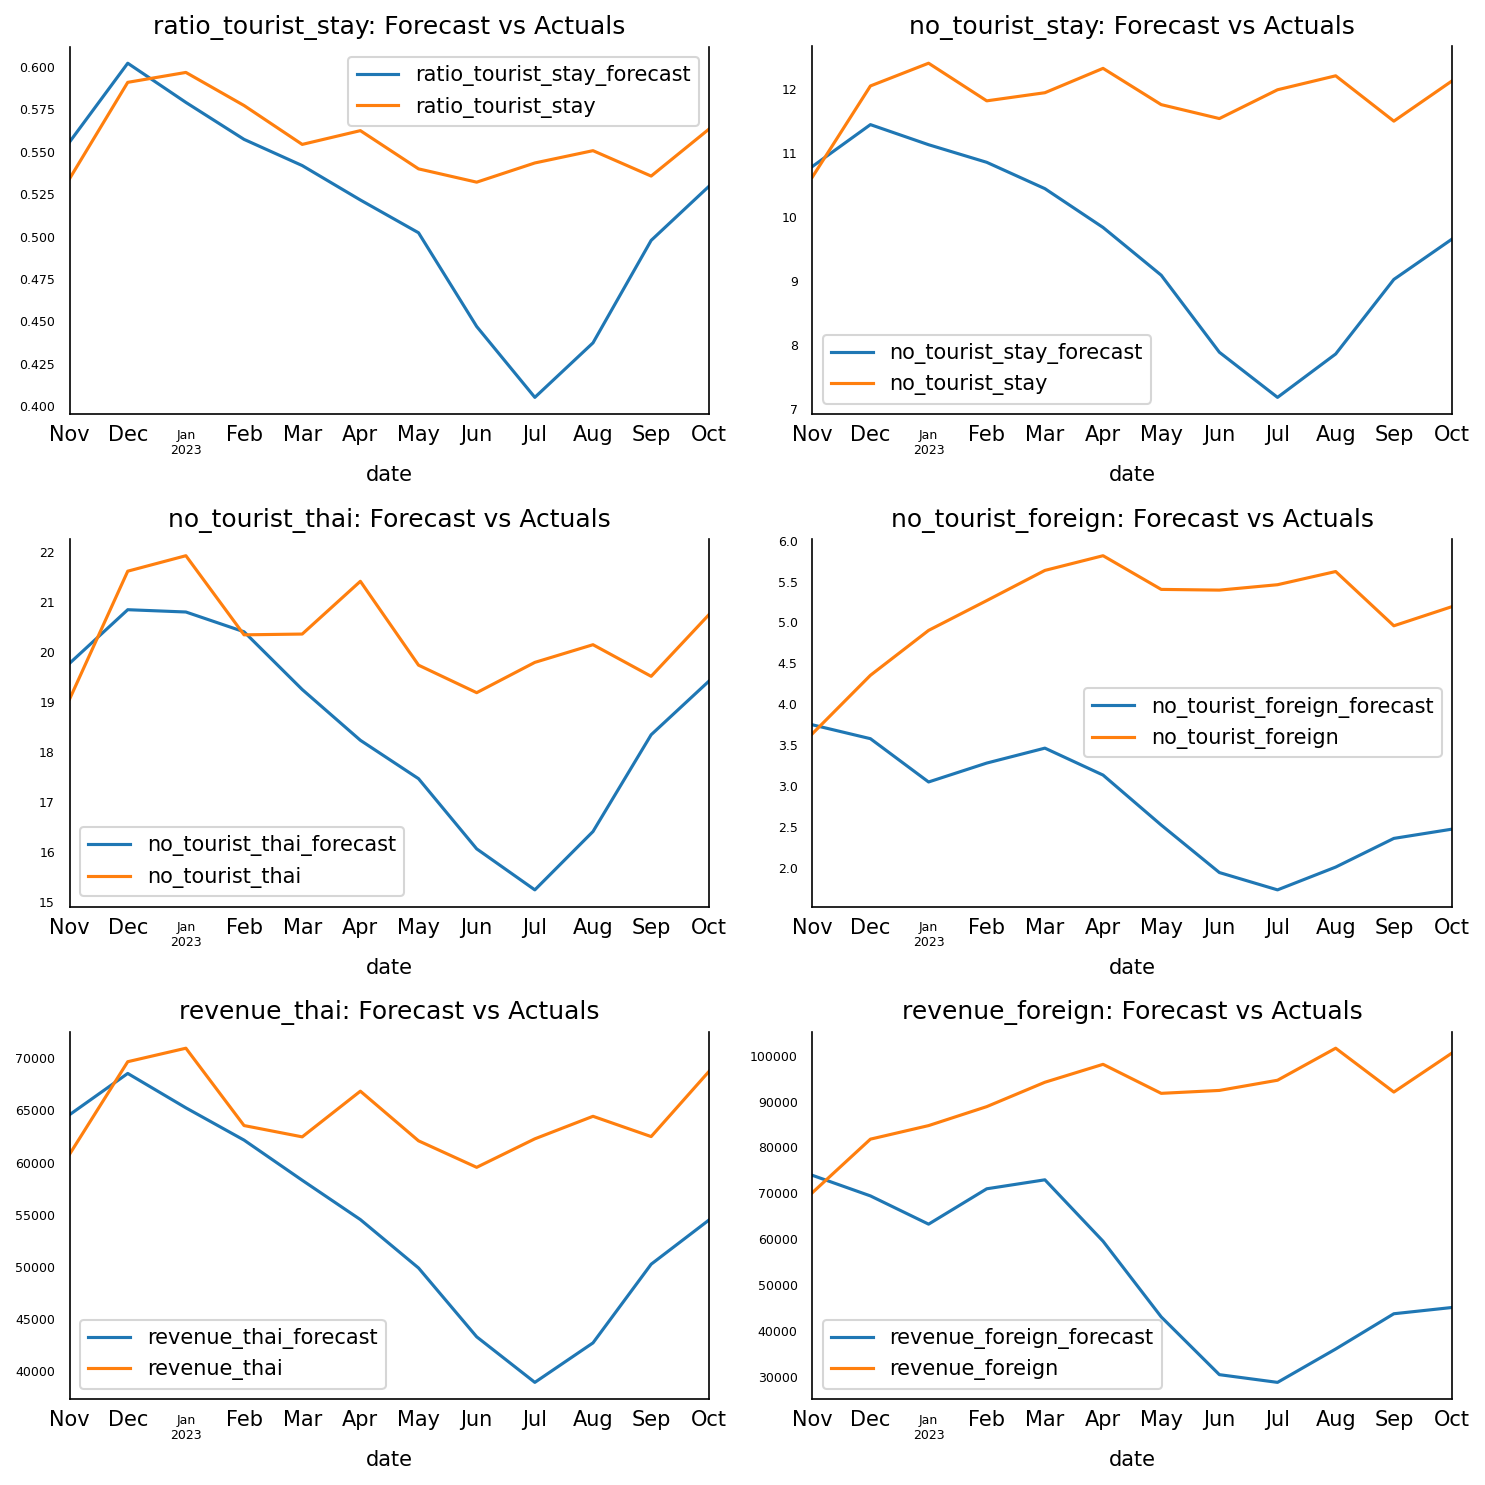

In [93]:
# Plot of Forecast vs Actuals
fig, axes = plt.subplots(nrows=int(len(train_thai_all.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_thai_all.columns, axes.flatten())):
    df_results[col+ "_forecast"].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_thai_all[col][-HOLDOUT_MONTH:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [94]:
import numpy as np

def forecast_metric(forecast, actual):
    forecast = np.array(forecast).flatten()
    actual = np.array(actual).flatten()

    mape_result = (np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100).round(2)
    rmspe_result = (
        (np.sqrt(np.mean(np.square((forecast - actual) / actual)))) * 100
    ).round(2)
    return {"RMSPE": rmspe_result, "MAPE": mape_result}


In [95]:
## Get metrics for all variable 

test_thai_all.head()

,ratio_tourist_stay,no_tourist_stay,no_tourist_thai,no_tourist_foreign,revenue_thai,revenue_foreign
date,,,,,,
2022-11-01,0.534165,10.620831,19.053211,3.637924,60802.940000,70128.140000
2022-12-01,0.591026,12.044518,21.613755,4.353607,69672.420000,81804.130000
2023-01-01,0.596877,12.399203,21.923313,4.902631,70965.529999,84756.359999
2023-02-01,0.577344,11.812097,20.339840,5.267222,63551.739999,88890.560000
2023-03-01,0.554387,11.938804,20.355368,5.636183,62468.270000,94200.830000


In [96]:
df_results.head()

,ratio_tourist_stay_forecast,no_tourist_stay_forecast,no_tourist_thai_forecast,no_tourist_foreign_forecast,revenue_thai_forecast,revenue_foreign_forecast
date,,,,,,
2022-11-01,0.555827,10.786803,19.770034,3.748445,64592.670369,73931.602452
2022-12-01,0.602319,11.441121,20.842733,3.578320,68547.178309,69438.464777
2023-01-01,0.579169,11.127640,20.796727,3.049045,65250.062239,63284.749279
2023-02-01,0.557360,10.853055,20.401080,3.280317,62156.639699,70987.925614
2023-03-01,0.541896,10.442175,19.245585,3.462799,58308.517913,72944.600179


In [97]:
 # Convert to normal column
df_results.columns = [col[:-len("_forecast")] for col in df_results.columns]

In [98]:
df_results.head()

,ratio_tourist_stay,no_tourist_stay,no_tourist_thai,no_tourist_foreign,revenue_thai,revenue_foreign
date,,,,,,
2022-11-01,0.555827,10.786803,19.770034,3.748445,64592.670369,73931.602452
2022-12-01,0.602319,11.441121,20.842733,3.578320,68547.178309,69438.464777
2023-01-01,0.579169,11.127640,20.796727,3.049045,65250.062239,63284.749279
2023-02-01,0.557360,10.853055,20.401080,3.280317,62156.639699,70987.925614
2023-03-01,0.541896,10.442175,19.245585,3.462799,58308.517913,72944.600179


In [99]:
df_results["no_tourist_all"] = df_results["no_tourist_thai"] + df_results["no_tourist_foreign"]
test_thai_all["no_tourist_all"] = test_thai_all["no_tourist_thai"] + test_thai_all["no_tourist_foreign"]

df_results["revenue_all"] = df_results["revenue_thai"] + df_results["revenue_foreign"]
test_thai_all["revenue_all"] = test_thai_all["revenue_thai"] + test_thai_all["revenue_foreign"]


C:\Users\DUC\AppData\Local\Temp\ipykernel_25444\3658736676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_thai_all["no_tourist_all"] = test_thai_all["no_tourist_thai"] + test_thai_all["no_tourist_foreign"]
C:\Users\DUC\AppData\Local\Temp\ipykernel_25444\3658736676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_thai_all["revenue_all"] = test_thai_all["revenue_thai"] + test_thai_all["revenue_foreign"]


In [100]:
for col in df_results.columns:
    print(col, forecast_metric(df_results[col], test_thai_all[col]))

ratio_tourist_stay {'RMSPE': 11.41, 'MAPE': 8.67}
no_tourist_stay {'RMSPE': 22.39, 'MAPE': 19.11}
no_tourist_thai {'RMSPE': 11.74, 'MAPE': 9.57}
no_tourist_foreign {'RMSPE': 48.33, 'MAPE': 44.65}
revenue_thai {'RMSPE': 20.37, 'MAPE': 16.8}
revenue_foreign {'RMSPE': 46.06, 'MAPE': 40.8}
no_tourist_all {'RMSPE': 19.06, 'MAPE': 16.84}
revenue_all {'RMSPE': 35.62, 'MAPE': 31.05}
